# Cuda Simulator

In [1]:
%load_ext pyinstrument
"""Setup"""
import numpy as np
import sys
#from google.colab import drive
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D
from viz_cuda import *
from optics_cuda import *

#drive.mount("/content/gdrive")
np.set_printoptions(
    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

CuPy version 11.0.0
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


In [2]:
%%time
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""

###
photon_count = np.int32(50000000)
source_size = np.float32(10)
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
###
photons = LambertianSource(source_size, source_size).make_photons(photon_count)

CPU times: user 249 ms, sys: 68.7 ms, total: 318 ms
Wall time: 335 ms


CPU times: user 128 ms, sys: 3.5 ms, total: 132 ms
Wall time: 128 ms


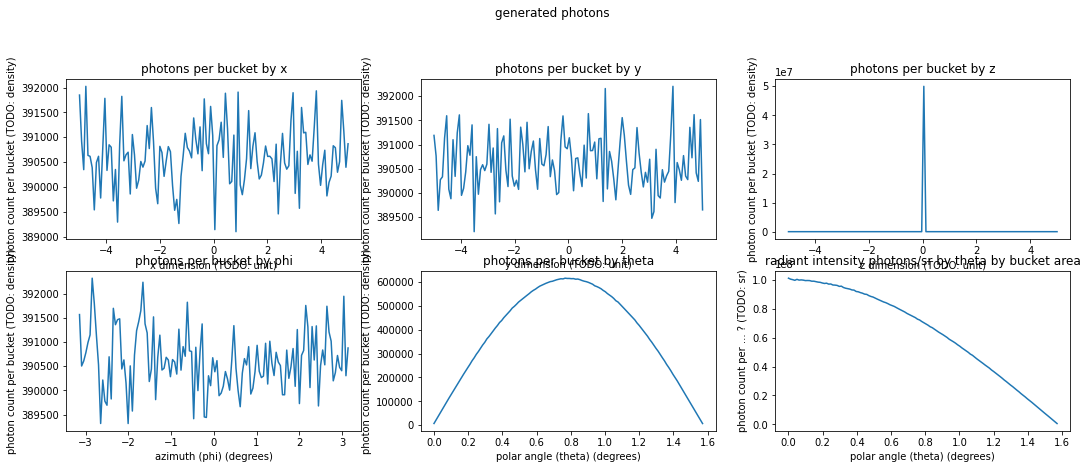

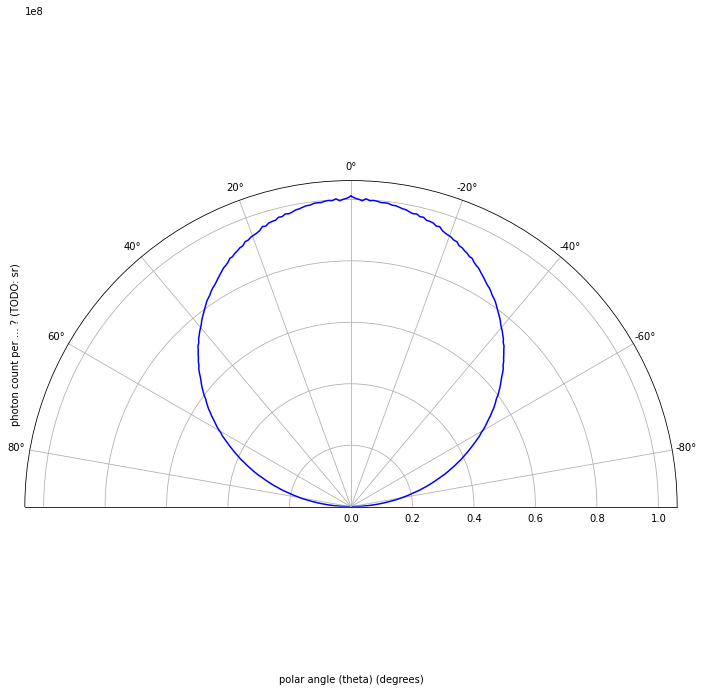

In [3]:
%%time
""" Look at the distributions of the generated photons."""
#plot_histogram_slices(photons, photon_count, "generated photons",
#                      -source_size/2, source_size/2, -source_size/2, source_size/2,
#                      z_min=-5, z_max=5, theta_max = np.pi/2)
plot_histogram_slices(photons, "generated photons",
                      x_min = -source_size/2, x_max = source_size/2,
                      y_min = -source_size/2, y_max = source_size/2,
                      z_min = -5, z_max = 5, theta_max = np.pi/2)

---

In [4]:
"""Look at the photons in 3d."""
plot_3d(photons)
#photons_viz = Photon.sample(photons, 1000)
#plot_rays([photons_viz], 5, 20, 15, 1, rectangles=[source_box])

Output()

---

In [ ]:
%%pyinstrument
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
###

print(f"LED emitted photons: {Photon.countAlive(photons)}")
lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")

In [ ]:
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000, theta_max = np.pi/2)

In [ ]:
%%pyinstrument
""" Diffuse through the diffuser. """
print(f"diffuser-incident photons: {Photon.countAlive(photons)}")
diffuser = Diffuser(g = 0.64, absorption = 0.16)
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
diffused_photons_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000)

In [ ]:
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz], elev = 10, azim = 30, size = max(lightbox_height, lightbox_size), arrow_length = 50,
          rectangles=[source_box, lightbox_box])

In [ ]:
%%pyinstrument
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# size might be 10cm square?
###
reflector_distance = 100000 # 1 m
reflector_box = [-500, 500, -500, 500, reflector_distance]
###
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
propagateToReflector(photons, location = reflector_distance, size = 1000)
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_reflector_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=reflector_distance)

In [ ]:
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz ], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 500,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
%%pyinstrument
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
reflector = Diffuser(g = -0.9925, absorption=0.0)
reflector.diffuse(photons)
print(f"reflected photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
reflected_photons_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=reflector_distance)

In [ ]:
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz, reflected_photons_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {Photon.countAlive(photons)}")
propagateToCamera(photons, location = lightbox_size) # make the camera height even with the diffuser
print(f"camera-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_camera_plane_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=1000)

In [ ]:
""" Show the reflected photons in 3d."""
plot_rays([reflected_photons_viz, photons_at_camera_plane_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
""" Show the distributions of reflected photons, close up """
plot_histogram_slices(photons, "reflected photons", x_min=-2000, x_max=2000, y_min=-2000, y_max=2000, z_min=0, z_max=1000)

In [ ]:
""" Look closer at the neighborhood of the detector. """
plot_rays([photons_at_camera_plane_viz], 
          elev = 90, azim = 0, size = 5000, arrow_length = 1000,
          rectangles=[source_box, lightbox_box])